In [30]:
import pandas as pd
import seaborn as sns
import sagemaker
import boto3
import os
from sagemaker.image_uris import retrieve
import io
import sagemaker.amazon.common as smac






In [17]:
sess = sagemaker.Session()
region = boto3.Session().region_name

In [18]:

# S3 bucket for saving code and model artifacts.
# Feel free to specify a different bucket and prefix
bucket = sess.default_bucket()
prefix = "angel-investor/pca"



In [19]:
# Define IAM role
import re
from sagemaker import get_execution_role

role = get_execution_role()


In [20]:
df_training = pd.read_csv("data/train_features.csv")
df_training

,funding_total_usd,funding_rounds,founded_year,category_list_software,category_list_biotechnology,category_list_curated web,category_list_hardware,category_list_mobile,category_list_clean technology,category_list_health,...,"region_washington, d.c.",region_wi - other,region_wichita,"region_wilmington - cape fear, north carolina","region_wilmington, delaware",region_winston-salem,region_worcester,region_wv - other,region_wy - other,region_youngstown
0,1000000.0,1.0,2013.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,25065701.0,2.0,2008.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,250000.0,1.0,2006.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,104124067.0,5.0,2002.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,24500000.0,4.0,2007.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14599,0.0,1.0,2012.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14600,2500000.0,1.0,2012.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14601,200000.0,1.0,2009.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14602,1000000.0,1.0,2005.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Checking redundancy of variable by using correlation matrices

In [21]:
corr = df_training.corr()

In [22]:
corr

,funding_total_usd,funding_rounds,founded_year,category_list_software,category_list_biotechnology,category_list_curated web,category_list_hardware,category_list_mobile,category_list_clean technology,category_list_health,...,"region_washington, d.c.",region_wi - other,region_wichita,"region_wilmington - cape fear, north carolina","region_wilmington, delaware",region_winston-salem,region_worcester,region_wv - other,region_wy - other,region_youngstown
funding_total_usd,1.000000,0.095181,-0.061869,-0.010350,0.009227,-0.010910,0.000109,0.014955,0.016719,0.007012,...,-0.000563,-0.001595,-0.001322,-0.000749,-0.001062,-0.000710,0.000131,-0.001200,-0.001169,-0.000815
funding_rounds,0.095181,1.000000,-0.058628,0.010796,0.093236,-0.034962,0.002590,0.024740,0.064725,0.048023,...,-0.003025,-0.005249,-0.011330,-0.002970,-0.017669,-0.009954,0.005857,-0.008382,-0.010985,-0.007079
founded_year,-0.061869,-0.058628,1.000000,-0.038323,-0.105667,0.055063,-0.055817,0.105368,-0.036902,-0.025159,...,-0.029995,-0.036361,0.000236,0.006604,0.008259,-0.000276,-0.012932,0.004588,0.004039,-0.007390
category_list_software,-0.010350,0.010796,-0.038323,1.000000,-0.189421,-0.138864,0.299868,-0.077618,-0.088455,-0.117266,...,0.026655,0.001297,0.003031,-0.002810,0.007238,-0.002810,-0.006288,-0.000643,0.008709,-0.004606
category_list_biotechnology,0.009227,0.093236,-0.105667,-0.189421,1.000000,-0.084522,-0.061057,-0.109277,-0.050148,0.008950,...,0.014282,0.005650,-0.006396,0.007061,-0.000494,0.007061,0.004254,-0.005222,-0.005222,-0.006396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
region_winston-salem,-0.000710,-0.009954,-0.000276,-0.002810,0.007061,-0.004958,-0.003726,-0.006544,-0.003192,0.036894,...,-0.003145,-0.000573,-0.000375,-0.000342,-0.000735,1.000000,-0.000766,-0.000306,-0.000306,-0.000375
region_worcester,0.000131,0.005857,-0.012932,-0.006288,0.004254,0.015412,-0.008338,-0.014642,0.022521,-0.011790,...,-0.007038,-0.001283,-0.000840,-0.000766,-0.001645,-0.000766,1.000000,-0.000685,-0.000685,-0.000840
region_wv - other,-0.001200,-0.008382,0.004588,-0.000643,-0.005222,-0.004434,-0.003333,-0.005853,0.021847,-0.004712,...,-0.002813,-0.000513,-0.000336,-0.000306,-0.000657,-0.000306,-0.000685,1.000000,-0.000274,-0.000336
region_wy - other,-0.001169,-0.010985,0.004039,0.008709,-0.005222,-0.004434,-0.003333,-0.005853,-0.002855,-0.004712,...,-0.002813,-0.000513,-0.000336,-0.000306,-0.000657,-0.000306,-0.000685,-0.000274,1.000000,-0.000336


<AxesSubplot:>

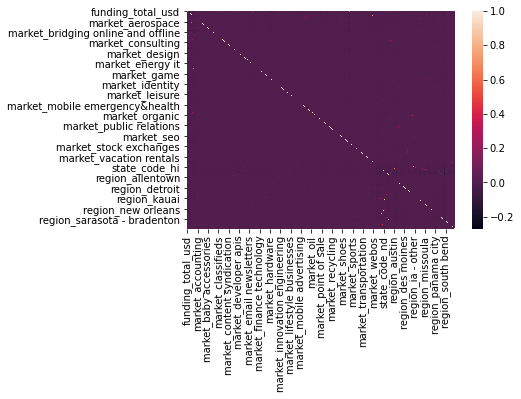

In [23]:
sns.heatmap(corr)

There appears to be very little correlation across features, which is a good thing for modeling purposes

### Principal Component Analysis to Check Redundancy of Variables

Converting traing data to recordIO-wrapped protobuf for PCA model after dropping the target variable.

In [24]:
df_training.dtypes

funding_total_usd              float64
funding_rounds                 float64
founded_year                   float64
category_list_software           int64
category_list_biotechnology      int64
                                ...   
region_winston-salem             int64
region_worcester                 int64
region_wv - other                int64
region_wy - other                int64
region_youngstown                int64
Length: 984, dtype: object

In [25]:
X_np_array = df_training.to_numpy()

In [26]:
num_columns = len(df_training.columns)

In [27]:
X_np_array

array([[1.0000000e+06, 1.0000000e+00, 2.0130000e+03, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [2.5065701e+07, 2.0000000e+00, 2.0080000e+03, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [2.5000000e+05, 1.0000000e+00, 2.0060000e+03, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [2.0000000e+05, 1.0000000e+00, 2.0090000e+03, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.0000000e+06, 1.0000000e+00, 2.0050000e+03, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [2.0000000e+06, 1.0000000e+00, 2.0130000e+03, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]])

In [31]:
buf = io.BytesIO()

In [32]:
smac.write_numpy_to_dense_tensor(buf, X_np_array)
buf.seek(0)

0

In [33]:

key = "recordio-pca-data"

In [34]:
boto3.resource("s3").Bucket(bucket).Object(os.path.join(prefix, "train", key)).upload_fileobj(buf)

In [35]:
s3_train_data = f"s3://{bucket}/{prefix}/train/{key}"
print(f"uploaded training data location: {s3_train_data}")
output_location = f"s3://{bucket}/{prefix}/output"
print(f"training artifacts will be uploaded to: {output_location}")

uploaded training data location: s3://sagemaker-us-east-1-215019911230/angel-investor/pca/train/recordio-pca-data
training artifacts will be uploaded to: s3://sagemaker-us-east-1-215019911230/angel-investor/pca/output


### Training Principal Component Model

In [36]:
container = retrieve(framework="pca", region=region)


pca = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    output_path=output_location,
    sagemaker_session=sess,
)
pca.set_hyperparameters(
    feature_dim=num_columns,
    num_components=50,
    subtract_mean=True,
    algorithm_mode="randomized",
    mini_batch_size=200,
)

pca.fit({"train": s3_train_data})

2021-08-04 06:31:39 Starting - Starting the training job...
2021-08-04 06:32:02 Starting - Launching requested ML instancesProfilerReport-1628058699: InProgress
...
2021-08-04 06:32:36 Starting - Preparing the instances for training............
2021-08-04 06:34:41 Downloading - Downloading input data
2021-08-04 06:34:41 Training - Downloading the training image...
2021-08-04 06:35:03 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[08/04/2021 06:35:07 INFO 139848314505024] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'algorithm_mode': 'regular', 'subtract_mean': 'true', 'extra_components': '-1', 'force_dense': 'true', 'epochs': 1, '_log_level': 'info', '_kvstore': 'dist_sync', '_num_kv_servers': 'auto', '_num_gpus': 'auto'}
[08/04/2021 06:35:07 INFO 139848314505024] Merging with provided configuration 

[2021-08-04 06:35:08.473] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 1, "duration": 249, "num_examples": 74, "num_bytes": 115371600}
#metrics {"StartTime": 1628058908.201161, "EndTime": 1628058908.4742007, "Dimensions": {"Algorithm": "PCA", "Host": "algo-1", "Operation": "training"}, "Metrics": {"epochs": {"sum": 1.0, "count": 1, "min": 1, "max": 1}, "update.time": {"sum": 268.1841850280762, "count": 1, "min": 268.1841850280762, "max": 268.1841850280762}}}

[08/04/2021 06:35:08 INFO 139848314505024] #progress_metric: host=algo-1, completed 100.0 % of epochs
#metrics {"StartTime": 1628058908.2059746, "EndTime": 1628058908.4747813, "Dimensions": {"Algorithm": "PCA", "Host": "algo-1", "Operation": "training", "epoch": 0, "Meta": "training_data_iter"}, "Metrics": {"Total Records Seen": {"sum": 14604.0, "count": 1, "min": 14604, "max": 14604}, "Total Batches Seen": {"sum": 74.0, "count": 1, "min": 74, "max": 74}, "Max Records Seen Between Resets": {

Retrieving the model artifacts to explore the PCA components

In [37]:
job_name = pca.latest_training_job.name
job_name

'pca-2021-08-04-06-31-39-568'

In [38]:
!aws s3api get-object --bucket "sagemaker-us-east-1-215019911230" --key "angel-investor/pca/output/$job_name/output/model.tar.gz" model.tar.gz

{
    "AcceptRanges": "bytes",
    "LastModified": "Wed, 04 Aug 2021 06:35:15 GMT",
    "ContentLength": 177252,
    "ETag": "\"a67b57ba303bb5e2298ea3e171c840d7\"",
    "ContentType": "application/x-gzip",
    "ServerSideEncryption": "aws:kms",
    "Metadata": {},
    "SSEKMSKeyId": "arn:aws:kms:us-east-1:215019911230:key/6d8f0101-ade2-488d-8a4f-d42145bd3757"
}


In [39]:

os.system("tar -zxvf model.tar.gz")

0

In [40]:
!ls

angel-investor-1-data_cleaning.ipynb	      data
angel-investor-2-data_exploration.ipynb       model_algo-1
angel-investor-3-model_training_tuning.ipynb  model.tar.gz
angel-investor-4-production_launch.ipynb      README.md


In [41]:
import mxnet as mx

In [42]:
pca_model_params = mx.ndarray.load("model_algo-1")

In [43]:
s = pd.DataFrame(pca_model_params["s"].asnumpy())
v = pd.DataFrame(pca_model_params["v"].asnumpy())

In [44]:
s.iloc[1:, :].apply(lambda x: x * x).sum() / s.apply(lambda x: x * x).sum()

0    8.978123e-16
dtype: float32

### The small amount of variance explained by principal component analysis is further evidence that variable reduction is not the best approach. All of the variables in the training data will be kept.

Cleaning up data that was downloaded

In [45]:
!rm model.tar.gz; rm model_algo-1;  rm train_from_s3.csv

rm: cannot remove ‘train_from_s3.csv’: No such file or directory


In [46]:
!ls

angel-investor-1-data_cleaning.ipynb
angel-investor-2-data_exploration.ipynb
angel-investor-3-model_training_tuning.ipynb
angel-investor-4-production_launch.ipynb
data
README.md
